## Some utilities

In [1]:
#default_exp core

In [3]:
#export
import pandas as pd
import uuid
import numpy as np
import random
import os

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
import pydoc

pd.set_option('display.max_colwidth', None)

In [21]:
#export
def object_from_dict(d, parent=None, **default_kwargs):
    kwargs = d.copy()
    object_type = kwargs.pop("type")
    for name, value in default_kwargs.items():
        kwargs.setdefault(name, value)

    if parent is not None:
        return getattr(parent, object_type)(**kwargs)  # skipcq PTC-W0034

    return pydoc.locate(object_type)(**kwargs)

In [19]:
model_config = dict(type='timm.create_model', model_name='tf_efficientnet_b4', pretrained=True)
print(model_config)
model = object_from_dict(model_config)

{'type': 'timm.create_model', 'model_name': 'tf_efficientnet_b4', 'pretrained': True}


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_aa-818f208c.pth" to /Users/ayushman/.cache/torch/hub/checkpoints/tf_efficientnet_b4_aa-818f208c.pth


In [20]:
model

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): DepthwiseSeparableConv

**Label map for the cassava categories**

In [22]:
#export
idx2lbl = {
    0: "Cassava Bacterial Blight (CBB)",
    1: "Cassava Brown Streak Disease (CBSD)",
    2: "Cassava Green Mottle (CGM)",
    3: "Cassava Mosaic Disease (CMD)",
    4: "Healthy",
}



conf_mat_idx2lbl = {
    0: "CBB",
    1: "CBSD",
    2: "CGM",
    3: "CMD",
    4: "Healthy",
}

In [23]:
#export
def seed_everything(seed: int) -> int:
    """sets a seed for the environment in :
       `pytorch`, `numpy`, `python.random` and sets `PYTHONHASHSEED` environment variable.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    return seed

In [24]:
seed_everything(42)

42

In [25]:
#export
def generate_random_id() -> str:
    "generates a random id"
    idx = uuid.uuid1()
    idx = str(idx).split("-")[0]
    return idx

In [26]:
generate_random_id()

'20d38654'

## Function to Load in the stratified pandas dataframe

In [27]:
#export
def load_dataset(pth: str, im_dir: str, curr_fold: int = 0, shuffle: bool = True) -> pd.DataFrame:
    "loads the dataframe and formats it"
    assert curr_fold < 5
    
    data = pd.read_csv(pth)
    
    data["filePath"] = [os.path.join(im_dir, data["image_id"][idx]) for idx in range(len(data))]
    data["is_valid"] = [data.kfold[n] == curr_fold for n in range(len(data))]
    data["label"].replace(idx2lbl, inplace=True)

    if shuffle: data = data.sample(frac=1).reset_index(drop=True, inplace=False)
    else      : data = data.reset_index(drop=True, inplace=False)

    return data

In [28]:
df = load_dataset('../../leaf-disease-classification-kaggle/data/stratified-data-5folds.csv', 
                 im_dir='../../Datasets/cassava/train_images/', curr_fold=0, shuffle=True)
df.head()

,image_id,label,filePath,kfold,is_valid
0,1587173996.jpg,Healthy,../../Datasets/cassava/train_images/1587173996.jpg,2,False
1,404115232.jpg,Cassava Mosaic Disease (CMD),../../Datasets/cassava/train_images/404115232.jpg,0,True
2,3945098769.jpg,Cassava Mosaic Disease (CMD),../../Datasets/cassava/train_images/3945098769.jpg,1,False
3,4037735151.jpg,Cassava Mosaic Disease (CMD),../../Datasets/cassava/train_images/4037735151.jpg,3,False
4,730805822.jpg,Cassava Mosaic Disease (CMD),../../Datasets/cassava/train_images/730805822.jpg,1,False


In [29]:
#export
class DummyDataset(torch.utils.data.Dataset):
    def __init__(self, data: pd.DataFrame):
        self.data = data
        
        self.transforms = A.Compose([A.RandomResizedCrop(224, 224, p=1.0),
                                     A.RandomBrightness(),
                                     A.HorizontalFlip(),
                                     A.IAASharpen(),
                                     A.Normalize(p=1.0),
                                     ToTensorV2(p=1.0)])
        
        self.lbl_dict = {v: k for k, v in idx2lbl.items()}
    
    def __len__(self): return len(self.data)
    
    def __getitem__(self, index):
        image = self.data['filePath'][index]
        label = self.data['label'][index]
        
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        image = self.transforms(image=image)['image']
        label = torch.tensor(self.lbl_dict[label])
        return image, label

In [30]:
#export
class ImageClassificationFromDf(torch.utils.data.Dataset):
    """
    Image classification dataset.
    Args:
        dataframe: dataframe with image_id and labels
        transformations: albumentation transformations
    """

    def __init__(self, dataframe: pd.DataFrame, transformations:A.Compose, lbl_dict:dict=None):
        self.df = dataframe
        self.transforms = transformations
        
        if lbl_dict is None: self.lbl_dict = {v: k for k, v in idx2lbl.items()}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_id = self.df['filePath'][idx]
        target = self.df['label'][idx]

        # Read an image with OpenCV
        img = cv2.imread(image_id)

        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # apply transformations to the image
        img = self.transforms(image=img)["image"]

        return img, torch.tensor(self.lbl_dict[target])

In [31]:
#export
class LabelSmoothingCrossEntropy(_WeightedLoss):
    "label smoothing loss"
    def __init__(self, eps:float=0.1, weight=None, reduction='mean'):
        super().__init__(weight=weight, reduction=reduction)
        self.weight = weight
        self.reduction = reduction
        self.eps = eps
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        if self.reduction=='sum': 
            loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1)
            if self.reduction=='mean':  
                loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target.long(), reduction=self.reduction)

In [32]:
import matplotlib.pyplot as plt
import torch
from torch import optim, nn

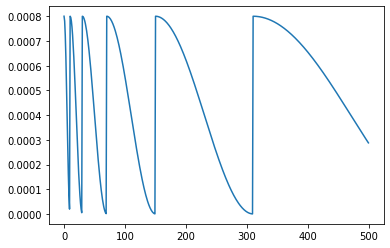

In [34]:
model = nn.Linear(10, 2)
optimizer = optim.AdamW(model.parameters(), lr=8e-4, eps=1e-05, betas=(0.9, 0.99))
steps = 500
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, last_epoch=-1)
lrs = []

for epoch in range(1):
    for idx in range(steps):
        optimizer.step()
        lrs.append(scheduler.get_lr())
        scheduler.step()
        
plt.plot(lrs)